In [362]:
import os
from PIL import Image, ImageFilter
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Import Annotation3D from matplotlib for 3d scatter plot
from mpl_toolkits.mplot3d.proj3d import proj_transform

from collections import defaultdict
import json
import torch
import torchvision
from sklearn.manifold import MDS
from tqdm import tqdm

ROOT = os.path.join("images", "svg")
# https://github.com/linssen/country-flag-icons

image_paths = [os.path.join(ROOT, nm) for nm in os.listdir(ROOT)]

COUNTRIES_PATH = os.path.join("images", "png", "countries")
png_paths = [os.path.join(COUNTRIES_PATH, nm) for nm in os.listdir(COUNTRIES_PATH)]

In [322]:
with open("code2country.json", "r") as f:
    code2country = json.load(f)

country2code = {v: k for k, v in code2country.items()}

code2country

{'afg': 'Afghanistan',
 'ago': 'Angola',
 'alb': 'Albania',
 'and': 'Andorra',
 'are': 'United Arab Emirates',
 'arg': 'Argentina',
 'arm': 'Armenia',
 'atg': 'Antigua and Barbuda',
 'aus': 'Australia',
 'aut': 'Austria',
 'aze': 'Azerbaijan',
 'bdi': 'Burundi',
 'bel': 'Belgium',
 'ben': 'Benin',
 'bfa': 'Burkina Faso',
 'bgd': 'Bangladesh',
 'bgr': 'Bulgaria',
 'bhr': 'Bahrain',
 'bhs': 'Bahamas',
 'bih': 'Bosnia and Herzegovina',
 'blr': 'Belarus',
 'blz': 'Belize',
 'bol': 'Bolivia',
 'bra': 'Brazil',
 'brb': 'Barbados',
 'brn': 'Brunei',
 'btn': 'Bhutan',
 'bwa': 'Botswana',
 'caf': 'Central African Republic',
 'can': 'Canada',
 'che': 'Switzerland',
 'chl': 'Chile',
 'chn': 'China',
 'civ': "CÃ´te d'Ivoire",
 'cmr': 'Cameroon',
 'cod': 'Democratic Republic of Congo',
 'cog': 'Republic of Congo',
 'col': 'Colombia',
 'com': 'Comoros',
 'cpv': 'Cape Verde',
 'cri': 'Costa Rica',
 'cub': 'Cuba',
 'cyp': 'Cyprus',
 'cze': 'Czechia',
 'deu': 'Germany',
 'dji': 'Djibouti',
 'dma': 'Dom

GDP and population for sorting

In [347]:
# Open GDPpC.json
with open("GDPpC.json", "r") as f:
    GDPpC = json.load(f)

In [348]:
# Open Population.json
with open("population.json", "r") as f:
    population = json.load(f)

# Compare the keys of Population and values of code2country
population_keys = set(population.keys())
countries = set(code2country.keys())

different_spellings_dict = {
    "Czech Republic": "Czechia",
    "Ivory Coast": "Côte d'Ivoire",
    "DR Congo": "Democratic Republic of Congo",
    "Congo": "Republic of Congo",
    "Turkey": "Türkiye",
}

# Print difference
print(sorted(population_keys - countries))
print(sorted(countries - population_keys))

# Save population json with only the countries in code2country, using the different spellings dict
# new_population = {country2code[k] if k in country2code else country2code[different_spellings_dict[k]]:v for k, v in population.items() if k in country2code or k in different_spellings_dict}

# Sort by code
# new_population = {k: new_population[k] for k in sorted(new_population.keys())}
# with open("population_new.json", "w") as f:
#     json.dump(new_population, f, indent=4)

[]
[]


China 24846800.0


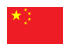

United States 21345360.4


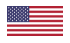

India 9189371.4


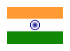

Japan 5079600.0


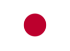

Germany 4479454.6695


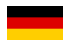

In [360]:
# Display flags in order of GDP

# Get GDP by multiplying population by GDP per capita
GDP = {k: population[k] * GDPpC[k] * 1e-6 for k in population.keys()}

# Sort by GDP
GDP = {k: GDP[k] for k in sorted(GDP.keys(), key=lambda x: GDP[x], reverse=True)}

# Display flags in order of GDP
for code, gdp in list(GDP.items())[:5]:
    print(code2country[code], gdp)

    # Plot the flag
    plt.figure(figsize=(1, 1))
    plt.imshow(Image.open(os.path.join(COUNTRIES_PATH, code + ".png")))
    plt.axis("off")
    plt.show()


c:\Users\321lu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


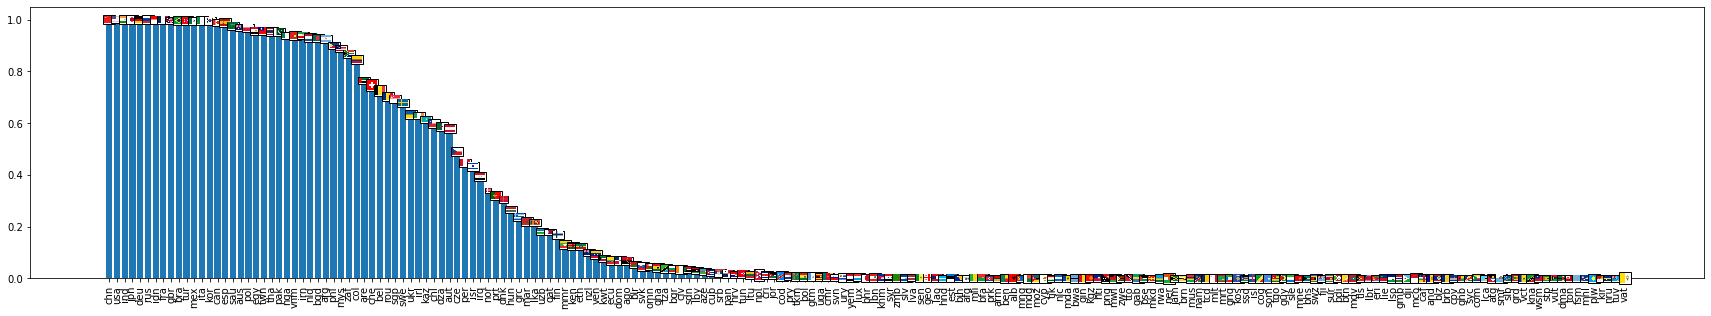

In [430]:
GDP_log = {k: np.log(v) for k, v in GDP.items()}
GDP_from_0 = {k: v-min(GDP_log.values()) for k, v in GDP_log.items()}
GDP_around_0 = {k: v-(np.mean(list(GDP_from_0.values()))*1.2) for k, v in GDP_from_0.items()}
GDP_closer_around_0 = {k: v/(np.mean(list(GDP_from_0.values()))/30) for k, v in GDP_around_0.items()}
GDP_sigmoid = {k: 1 / (1 + np.exp(-v)) for k, v in GDP_closer_around_0.items()}

# Plot barchart of GDP
plt.figure(figsize=(30, 5))
plt.bar(range(len(GDP)), list(GDP_sigmoid.values()), align="center")

# Add flags to barchart
for i, (code, gdp) in enumerate(GDP_sigmoid.items()):
    im = Image.open(os.path.join(COUNTRIES_PATH, code + ".png"))
    im.thumbnail((50, 50), Image.ANTIALIAS)
    imagebox = OffsetImage(im, zoom=0.2)
    ab = AnnotationBbox(imagebox, (i, gdp), xybox=(0, 0), xycoords="data", boxcoords="offset points", pad=0.1)
    plt.gca().add_artist(ab)

plt.xticks(range(len(GDP)), list(GDP.keys()), rotation=90)
plt.show()

# Most stuff before malaysia is probably known
# Turning point should probably be around Sri Lanka

# Save json of GDP probabilities
with open("json/GDP_probabilities.json", "w") as f:
    json.dump(GDP_sigmoid, f)

SVG 2 PNG Conversion

In [3]:
# from cairosvg import svg2png

# for path in image_paths:
#     with open(path, "r") as f:
#         content = f.read()
#     with open(path.replace("svg", "png"), "w") as f:
#         svg2png(content, f)

In [4]:
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPM
# import PIL
# import numpy as np
# from matplotlib import pyplot as plt

# for path in image_paths:
#     content = svg2rlg(path)
#     pil = renderPM.drawToPIL(content)
#     plt.imshow(np.array(pil))
#     pil.save(path.replace("svg", "png"), "PNG")
#     renderPM.drawToFile(content, path.replace("svg", "png"), fmt='PNG')

In [324]:
INKSCAPE_PATH = os.path.join("C:\\","Program Files","Inkscape","bin","inkscape.exe")
"""https://inkscape.org/doc/inkscape-man.html"""

def convert_svgs_to_png(image_paths):
    for path in image_paths:
        save_path = path.replace('svg', 'png')
        command = f""" "{INKSCAPE_PATH}" --export-filename="{save_path}" "{path}" """
        # print(command)
        stream = os.popen(command)
        # print(stream)
    # plt.savefig(,pad_inches = 0)

# Only kos.svg
# convert_svgs_to_png([os.path.join(ROOT, "kos.svg")])

COLOR

In [361]:
# load the color distributions from json file named "color_distribs.json"
with open("color_distribs.json", "r") as f:
    color_distrs = json.load(f)

# convert the inner keys back to tuples
color_distrs = {k:{tuple(eval(kk)):vv for kk,vv in v.items()} for k,v in color_distrs.items()}
color_distrs

{'afg': {(1.0, 1.0, 1.0): 88.0, (0.0, 0.0, 0.0): 9.0},
 'ago': {(0.8, 0.04, 0.18): 48.0, (0.0, 0.0, 0.0): 47.0, (1.0, 0.8, 0.0): 4.0},
 'alb': {(1.0, 0.0, 0.0): 87.0, (0.0, 0.0, 0.0): 12.0},
 'and': {(0.06, 0.02, 0.62): 32.0,
  (0.84, 0.0, 0.2): 32.0,
  (1.0, 0.87, 0.0): 27.0,
  (0.78, 0.67, 0.46): 4.0,
  (0.84, 0.17, 0.12): 1.0},
 'are': {(0.0, 0.0, 0.0): 25.0,
  (0.0, 0.45, 0.18): 25.0,
  (1.0, 0.0, 0.0): 25.0,
  (1.0, 1.0, 1.0): 25.0},
 'arg': {(0.45, 0.67, 0.87): 66.0, (1.0, 1.0, 1.0): 31.0},
 'arm': {(0.0, 0.2, 0.63): 33.0,
  (0.85, 0.0, 0.07): 33.0,
  (0.95, 0.66, 0.0): 33.0},
 'atg': {(0.81, 0.07, 0.15): 50.0,
  (0.0, 0.0, 0.0): 26.0,
  (0.0, 0.45, 0.78): 11.0,
  (1.0, 1.0, 1.0): 8.0,
  (0.99, 0.82, 0.09): 5.0},
 'aus': {(0.0, 0.13, 0.41): 79.0,
  (1.0, 1.0, 1.0): 11.0,
  (0.89, 0.0, 0.17): 9.0},
 'aut': {(0.78, 0.06, 0.18): 67.0, (1.0, 1.0, 1.0): 33.0},
 'aze': {(0.0, 0.71, 0.89): 33.0,
  (0.31, 0.62, 0.18): 33.0,
  (0.94, 0.2, 0.25): 32.0,
  (1.0, 1.0, 1.0): 2.0},
 'bdi': {(1.

In [175]:
def RGB2HSL(RGB, lookup=True):
    """Convert RGB color vector into HSL color space. Returns a 3-element vector, HSL, which contains the H, S, and L values, 
    which range from 0 to 360, 0 to 1.0, and 0 to 1.0, respectively."""
    if HSL_lookup and lookup:
        return HSL_dict[tuple(RGB)]

    # RGB values lie between 0 to 1.0
    assert 0 <= RGB[0] <= 1.0 and 0 <= RGB[1] <= 1.0 and 0 <= RGB[2] <= 1.0

    # Conversion
    Cmax = np.max(RGB)
    Cmin = np.min(RGB)
    delta = Cmax - Cmin

    # Hue
    if delta == 0:
        H = 0
    elif Cmax == RGB[0]:
        H = 60 * (((RGB[1] - RGB[2]) / delta) % 6)
    elif Cmax == RGB[1]:
        H = 60 * (((RGB[2] - RGB[0]) / delta) + 2)
    elif Cmax == RGB[2]:
        H = 60 * (((RGB[0] - RGB[1]) / delta) + 4)

    # Lightness
    L = (Cmax + Cmin) / 2

    # Saturation
    if delta == 0:
        S = 0
    else:
        S = delta / (1 - np.abs(2 * L - 1))

    return np.array([H, S, L])

In [363]:
# Make dictionary for looking up Lab color from RGB color for each color in the color distributions
HSL_lookup = False
HSL_dict = {} # {RGB: HSL}
for code, colors in color_distrs.items():
    for color in colors:
        if color not in HSL_dict:
            HSL_dict[color] = RGB2HSL(np.array(color))

HSL_lookup = True

In [125]:
def HSL_dist(color1, color2, weights=[5,1,1]):
    """Computes a custom distance between two colors in HSL space"""
    color1, color2 = RGB2HSL(color1), RGB2HSL(color2)

    H_dist = min(abs(color1[0]-color2[0]), 360-abs(color1[0]-color2[0]))/180
    S_dist = abs(color1[1]-color2[1])
    L_dist = abs(color1[2]-color2[2])
    return np.sqrt((weights[0]*H_dist)**2 + (weights[1]*S_dist)**2 + (weights[2]*L_dist)**2)

def HSL_similarity(color1, color2, weights=[5,1,1]):
    """Computes a custom similarity between two colors in HSL space"""
    max_dist = np.sqrt((weights[0])**2 + (weights[1])**2 + (weights[2])**2)
    return 1 - HSL_dist(color1, color2, weights) / max_dist

def get_nearest_color(color, color_distr, dist_fn=HSL_dist, factor=1):
    """Get the color in color_distr that has the lowest distance to color. 
    Can set factor to -1 to get the color with the highest distance, or similarity if dist_fn is a similarity function."""
    min_distance = np.inf
    for color2 in color_distr.keys():
        color2 = np.array(color2)
        distance = dist_fn(color, color2) * factor
        if distance < min_distance:
            min_distance = distance
            nearest_color = color2
    return nearest_color, min_distance

def calc_color_distrib_similarity(color_distr1, color_distr2, sim_fn=HSL_similarity):
    """Calculate the similarity between two color distributions uniformly weighted"""
    similarity = 0.
    color_ctr = 0
    for color1, percent1 in color_distr1.items():
        color1 = np.array(color1)
        color2, neg_sim = get_nearest_color(color1, color_distr2, sim_fn, factor=-1)

        # Do a little hardcoded hack to ignore white unless it's both white, and same with black
        # This is especially important when using HSL because we emphasize the H
        from_white, to_white = np.mean(color1) >= 0.97, np.mean(color2) >= 0.97
        from_black, to_black = np.mean(color1) <= 0.03, np.mean(color2) <= 0.03
        if (from_white or from_black) and not (to_white or to_black):
            color_ctr += 0.1
            continue
        elif (to_white or to_black) and not (from_white or from_black):
            color_ctr += 1
            continue

        sim = -neg_sim
        similarity += sim
        color_ctr += 1

    return similarity / max(1,color_ctr)

def calc_color_distrib_similarity_matrix_symmetrical(color_distrs, sim_fn=HSL_similarity):
    """Calculate the similarities between all pairs of color distributions as NxN matrix"""
    countries = list(color_distrs.keys())
    N = len(countries)
    similarity_matrix = np.zeros((N,N))
    for i in tqdm(range(N)):
        for j in range(N):
            if i > j:
                similarity_matrix[i,j] = similarity_matrix[j,i]
                continue

            similarity_matrix[i,j] = np.round(min(
                calc_color_distrib_similarity(color_distrs[countries[i]], color_distrs[countries[j]], sim_fn=sim_fn),
                calc_color_distrib_similarity(color_distrs[countries[j]], color_distrs[countries[i]], sim_fn=sim_fn)
            ), 2)
    similarity_matrix = similarity_matrix / similarity_matrix.max()
    return similarity_matrix


In [364]:
color_dist_matrix = 1 - calc_color_distrib_similarity_matrix_symmetrical(color_distrs)

100%|██████████| 197/197 [00:08<00:00, 22.57it/s]


0.0 1.0


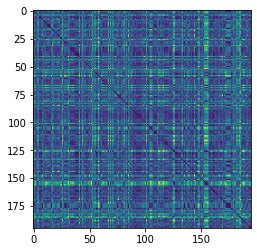

In [128]:
# Plot the similarity matrix
# plt.figure(figsize=(20,20))
plt.imshow(color_dist_matrix)
print(color_dist_matrix.min(), color_dist_matrix.max())

In [365]:
# Save color_dist_matrix to json file
with open("color_dist_matrix.json", "w") as f:
    json.dump(color_dist_matrix.tolist(), f)

EDGES

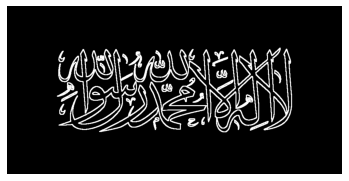

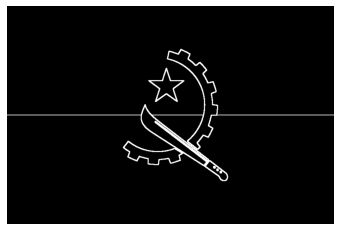

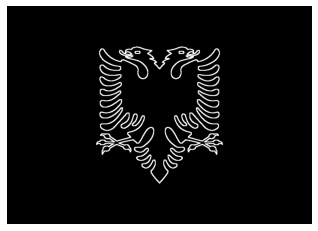

In [366]:
def edge_detect(img):
    """Simple edge detector by convolving with a 3x3 kernel. Give NCHW or CHW tensor, return N1HW or 1HW array"""
    # horizontal edge detector
    hkernel = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]).astype(np.float32)
    # vertical edge detector
    vkernel = np.array([[1,0,-1],[1,0,-1],[1,0,-1]]).astype(np.float32)
    # diagonal edge detector
    d1kernel = np.array([[1,0,-1],[0,0,0],[-1,0,1]]).astype(np.float32)
    # diagonal edge detector
    d2kernel = np.array([[-1,0,1],[0,0,0],[1,0,-1]]).astype(np.float32)

    img = np.array(img) # NCHW or CHW
    if len(img.shape) == 3:
        img = img[None,:,:,:] # CHW -> NCHW
    img = img.mean(axis=1, keepdims=True) # NCHW -> N1HW
    img = img.astype(np.float32)
    img = torch.tensor(img)

    img = torch.nn.functional.pad(img, (1,1,1,1), mode="replicate")
    h_edges = torch.nn.functional.conv2d(img, torch.tensor(hkernel).unsqueeze(0).unsqueeze(0))
    v_edges = torch.nn.functional.conv2d(img, torch.tensor(vkernel).unsqueeze(0).unsqueeze(0))
    d1_edges = torch.nn.functional.conv2d(img, torch.tensor(d1kernel).unsqueeze(0).unsqueeze(0))
    d2_edges = torch.nn.functional.conv2d(img, torch.tensor(d2kernel).unsqueeze(0).unsqueeze(0))
    img = h_edges**2 + v_edges**2 + d1_edges**2 + d2_edges**2
    img[img>0.0001] = 1
    img = img.squeeze(0) # 11HW -> 1HW

    return img.numpy()

# Show edge detection
for path in png_paths[:3]:
    img = Image.open(path)
    img = np.array(img).transpose(2,0,1) # HWC -> CHW
    # img = img.resize((128,128))
    img = edge_detect(img)
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.axis("Off")
    plt.show()

100%|██████████| 20/20 [00:03<00:00,  5.48it/s]


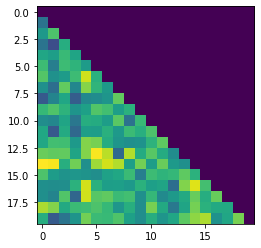

In [19]:
resize = torchvision.transforms.Resize((66,66))

countries = [code2country[path.split("\\")[-1].split(".")[0]] for path in png_paths]

"""Create NxN matrix of countries where N is the number of countries in the dataset.
The value at (i,j) is the MSE between the two countries' flags."""


def get_mse(img1, img2):
    return np.square(img1 - img2).mean()

def get_mse_matrix(png_paths):
    matrix = np.zeros((len(png_paths), len(png_paths)))
    for i in tqdm(range(len(png_paths))):
        img1 = np.array(Image.open(png_paths[i]))[:,:,:3]
        pil1 = Image.fromarray(img1)
        resized1 = resize(pil1)
        resized1 = np.array(resized1)
        for j in range(len(png_paths)):
            if i <= j:
                continue
            img2 = np.array(Image.open(png_paths[j]))[:,:,:3]
            pil2 = Image.fromarray(img2)
            resized2 = resize(pil2)
            resized2 = np.array(resized2)

            matrix[i,j] = get_mse(resized1, resized2)
    return matrix

mse_matrix = get_mse_matrix(png_paths[:20])

plt.imshow(mse_matrix)

Methods to see distance between flags:
- MSE
- MSE of flipped image
- MSE of colors permuted (no idea how I'd implement this)
- MSE of edges
- MSE of blurred edges (or even blurred images)
- distance between color distributions (maybe just the sum of R, G and B, or maybe cluster most common colors and see how much there is of those)
- make encodings (potentially with distortions) and get distance between them

check why edges mse of iceland and norway is so high

In [249]:
def RGB2HSLvectorized(RGB):
    """Converts an Nx3 matrix to an Nx3 matrix where each pixel is in HSL space, using matrix multiplication and numpy."""
    RGB = RGB.astype(np.float32)
    R = RGB[:,0]
    G = RGB[:,1]
    B = RGB[:,2]
    Cmax = RGB.max(axis=1)
    Cmin = RGB.min(axis=1)
    # Make sure delta is not 0
    delta = np.clip(Cmax - Cmin, 1e-8, None)
    L = (Cmax + Cmin) / 2
    # Make sure denominator is not 0
    denominator = np.clip(1 - np.abs(2*L - 1), 1e-8, None)
    S = delta / denominator
    H = np.zeros_like(L)
    H[Cmax == R] = 60 * (((G-B)/delta) % 6)[Cmax == R]
    H[Cmax == G] = 60 * (((B-R)/delta) + 2)[Cmax == G]
    H[Cmax == B] = 60 * (((R-G)/delta) + 4)[Cmax == B]
    HSL = np.stack([H,S,L], axis=1)
    return HSL

def RGBmatrix2HSLmatrix(RGBmatrix):
    """Converts an Nx3xHxW matrix to an Nx3xHxW matrix where each pixel is in HSL space, using RGB2HSLvectorized and reshaping when necessary."""
    N, _, H, W = RGBmatrix.shape
    RGBmatrix = RGBmatrix.transpose(0,2,3,1)
    RGBmatrix = RGBmatrix.reshape(-1,3)
    HSLmatrix = RGB2HSLvectorized(RGBmatrix)
    HSLmatrix = HSLmatrix.reshape(N,H,W,3)
    HSLmatrix = HSLmatrix.transpose(0,3,1,2)
    return HSLmatrix

def get_mse_matrix_vectorized(png_paths, edges=False, size=66, HSL=False, hflip=False, vflip=False, rot90=False, rot270=False):
    """construct two matrices containing all flags, one for each country.
    Then subtract the two matrices and square the result. The mean of this matrix
    is the MSE between the two countries' flags."""
    # Flag matrix base (N, 3, 66, 66), where N is the number of countries
    flag_matrix = np.zeros((len(png_paths), 3, size, size))
    for i in tqdm(range(len(png_paths))):
        img = np.array(Image.open(png_paths[i]))[:,:,:3] # (H, W, 3)
        pil = Image.fromarray(img)
        resized = pil.resize((size,size))
        resized = np.array(resized)
        flag_matrix[i] = resized.transpose(2,0,1)

    if flag_matrix.max() > 1:
        flag_matrix = flag_matrix / 255

    if edges:
        flag_matrix = edge_detect(flag_matrix)
    elif HSL:
        flag_matrix = RGBmatrix2HSLmatrix(flag_matrix)

    # Flag matrix 1 (NxN, C, 66, 66) where the first N 3D matrices are the same, the second N 3D matrices are the same, etc.
    flag_matrix1 = np.repeat(flag_matrix, len(png_paths), axis=0)
    # Flag matrix 2 (NxN, C, 66, 66) where the first N 3D matrices are all different, the second N 3D matrices are all different, etc.
    flag_matrix2 = np.tile(flag_matrix, (len(png_paths), 1, 1, 1))
    if hflip:
        flag_matrix2 = flag_matrix2[:,:,::-1,:]
    if vflip:
        flag_matrix2 = flag_matrix2[:,:,:,::-1]
    if rot90:
        flag_matrix2 = np.rot90(flag_matrix2, axes=(2,3))
    if rot270:
        flag_matrix2 = np.rot90(flag_matrix2, axes=(3,2))

    # Subtract the two matrices and square the result (NxN, C, 66, 66)
    if HSL:
        # Take into account that H is a circular variable
        diff_matrix = np.abs(flag_matrix1 - flag_matrix2)
        diff_matrix[:,0] = np.minimum(diff_matrix[:,0], 360 - diff_matrix[:,0]) / 180 # divide by 180 to normalize
        diff_matrix = diff_matrix**2
    else:
        diff_matrix = (flag_matrix1 - flag_matrix2)**2

    # Take the mean of the matrix (NxN)
    mse_matrix = diff_matrix.mean(axis=1).mean(axis=1).mean(axis=1)
    # Reshape to (N, N)
    mse_matrix = mse_matrix.reshape(len(png_paths), len(png_paths))
    return mse_matrix / mse_matrix.max()

In [250]:
# Import colorsys to convert RGB to HSL
import colorsys

# Test RGB2HSLvectorized using RGB float values
RGB = np.random.rand(100,3)
HSL_v = RGB2HSLvectorized(RGB)
HSL = np.array([RGB2HSL(rgb, False) for rgb in RGB])
HSL2 = np.array([colorsys.rgb_to_hls(*rgb) for rgb in RGB])
HSL2[:,0] = HSL2[:,0] * 360
# Switch axis 1 and 2 in HSL2
HSL2 = np.stack([HSL2[:,0], HSL2[:,2], HSL2[:,1]], axis=1)

np.allclose(HSL_v, HSL2)

# print(HSL2[:,0].max())
# print(HSL[:,0].max())
# print(HSL_v[:,0].max())
# print()
# print(HSL2[:,1].max())
# print(HSL[:,1].max())
# print(HSL_v[:,1].max())
# print()
# print(HSL2[:,2].max())
# print(HSL[:,2].max())
# print(HSL_v[:,2].max())
# print()
# print(HSL2[:,0].min())
# print(HSL[:,0].min())
# print(HSL_v[:,0].min())
# print()
# print(HSL2[:,1].min())
# print(HSL[:,1].min())
# print(HSL_v[:,1].min())
# print()
# print(HSL2[:,2].min())
# print(HSL[:,2].min())
# print(HSL_v[:,2].min())

True

100%|██████████| 197/197 [00:03<00:00, 53.52it/s]


0.0 1.0


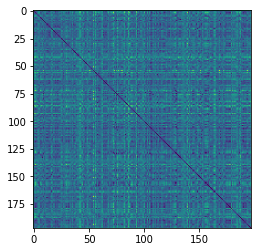

In [367]:
mse_matrix = get_mse_matrix_vectorized(png_paths[:], HSL=False)

# Plot and show range
plt.imshow(mse_matrix)

# Get the range of MSE values
print(mse_matrix.min(), mse_matrix.max())

# Save the matrix as json
with open("flag_mse_matrix.json", "w") as f:
    json.dump(mse_matrix.tolist(), f)

In [368]:
mse_matrix_hflip = get_mse_matrix_vectorized(png_paths[:], hflip=True)
mse_matrix_vflip = get_mse_matrix_vectorized(png_paths[:], vflip=True)
mse_matrix_rot90 = get_mse_matrix_vectorized(png_paths[:], rot90=True)
mse_matrix_rot270 = get_mse_matrix_vectorized(png_paths[:], rot270=True)

100%|██████████| 197/197 [00:03<00:00, 52.87it/s]


In [369]:
# Take the minimum of the 5 matrices to get the final matrix
mse_matrix_transforms = np.minimum(
    mse_matrix, np.minimum(
    mse_matrix_hflip**(1/2), np.minimum(
    mse_matrix_vflip**(1/2), np.minimum(
    mse_matrix_rot90**(1/3), 
    mse_matrix_rot270**(1/3)
))))

mse_matrix_flips = np.minimum(
    mse_matrix, np.minimum(
    mse_matrix_hflip,
    mse_matrix_vflip
))

mse_matrix_rotations = np.minimum(
    mse_matrix, np.minimum(
    mse_matrix_rot90,
    mse_matrix_rot270
))

In [370]:
with open("flag_mse_matrix_flips.json", "w") as f:
    json.dump(mse_matrix_flips.tolist(), f)

with open("flag_mse_matrix_rotations.json", "w") as f:
    json.dump(mse_matrix_rotations.tolist(), f)

100%|██████████| 197/197 [00:03<00:00, 53.43it/s]


0.0 1.0


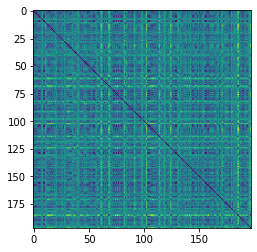

In [371]:
mse_matrix_edges = get_mse_matrix_vectorized(png_paths[:], edges=True, size=33)

plt.imshow(mse_matrix_edges)

# Get the range of MSE values
print(mse_matrix_edges.min(), mse_matrix_edges.max())

# Save the matrix as json
with open("flag_edges_mse_matrix.json", "w") as f:
    json.dump(mse_matrix_edges.tolist(), f)

SANITY CHECK

0.06795225 0.57794535


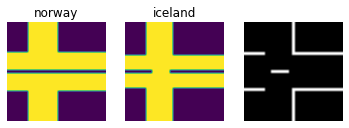

In [106]:
# plot random example of a pair of flags in a row with its MSE
i = np.random.randint(len(png_paths))
j = np.random.randint(len(png_paths))

i = list(code2country.values()).index("norway")
j = list(code2country.values()).index("iceland")

# get pair of flags with lowest MSE
# i,j = np.unravel_index(np.argmin(mse_matrix_edges), mse_matrix_edges.shape)

resize = torchvision.transforms.Resize((33,33))

img1 = np.array(Image.open(png_paths[i]))[:,:,:3]
pil1 = Image.fromarray(img1)
resized1 = resize(pil1)
resized1 = np.array(resized1)
img2 = np.array(Image.open(png_paths[j]))[:,:,:3]
pil2 = Image.fromarray(img2)
resized2 = resize(pil2)
resized2 = np.array(resized2)

# Do edge detection
edges = True
if edges:
    resized1 = edge_detect(resized1.transpose(2,0,1)).squeeze(0)
    resized2 = edge_detect(resized2.transpose(2,0,1)).squeeze(0)

    # # Blur the edges using PIL
    # resized1 = Image.fromarray((resized1*255).astype(np.uint8))
    # resized1 = resized1.filter(ImageFilter.GaussianBlur(radius=5))
    # resized2 = Image.fromarray((resized2*255).astype(np.uint8))
    # resized2 = resized2.filter(ImageFilter.GaussianBlur(radius=5))

    # Convert back to numpy array
    resized1 = np.array(resized1)[None,:,:]
    resized2 = np.array(resized2)[None,:,:]

se_img = np.square(resized1 - resized2)
if edges:
    se_img = se_img.squeeze(0)
else:
    se_img = se_img.mean(axis=2)

mse = se_img.mean()
if edges:
    print(mse, mse_matrix_edges[i,j])

else:
    print(mse, mse_matrix[i,j])

plt.subplot(1,3,1)
plt.imshow(resized1.squeeze(0))
plt.title(list(code2country.values())[i])
plt.axis("Off")
plt.subplot(1,3,2)
plt.imshow(resized2.squeeze(0))
plt.title(list(code2country.values())[j])
plt.axis("Off")
plt.subplot(1,3,3)
plt.imshow(se_img, cmap="gray", vmin=0, vmax=1)
plt.axis("Off")
plt.show()

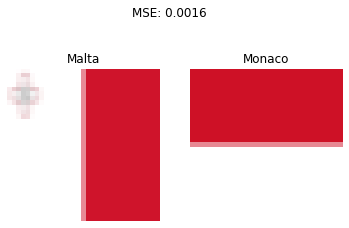

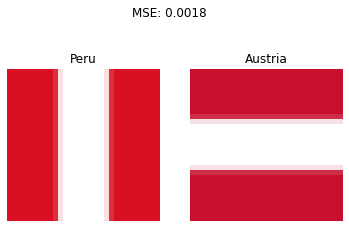

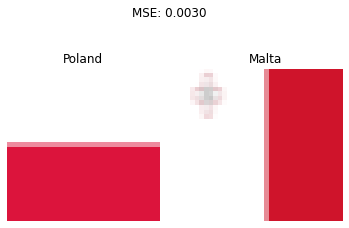

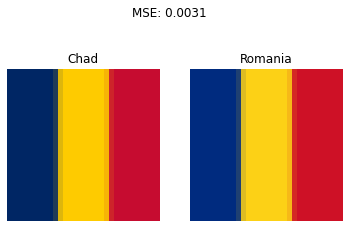

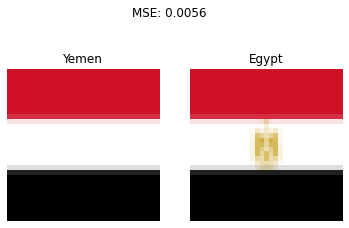

In [373]:
def display_top_pairs(matrix, amount=5):
    countries = list(code2country.values())

    # Get list of pairs of countries sorted by MSE
    pairs = []
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i <= j:
                continue
            pairs.append((countries[i], countries[j], matrix[i,j]))

    pairs = sorted(pairs, key=lambda x: x[2])

    # Display flags of countries with lowest MSE
    for pair in pairs[:amount]:
        img1 = np.array(Image.open(png_paths[countries.index(pair[0])]))[:,:,:3]
        img2 = np.array(Image.open(png_paths[countries.index(pair[1])]))[:,:,:3]
        pil1 = Image.fromarray(img1)
        pil2 = Image.fromarray(img2)
        resized1 = resize(pil1)
        resized2 = resize(pil2)
        resized1 = np.array(resized1)
        resized2 = np.array(resized2)
        # Plot flags in one row, with country as title, MSE in the middle
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(resized1)
        ax[0].set_title(pair[0])
        ax[0].axis("Off")
        ax[1].imshow(resized2)
        ax[1].set_title(pair[1])
        ax[1].axis("Off")
        plt.suptitle(f"MSE: {pair[2]:.4f}")
        plt.show()

display_top_pairs(mse_matrix_rotations, amount=5)

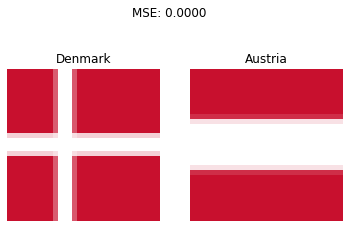

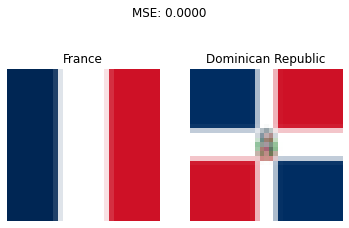

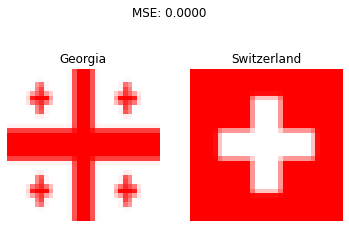

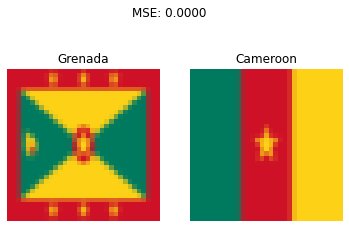

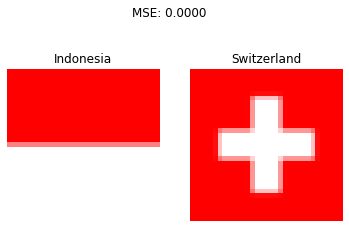

In [374]:
display_top_pairs(color_dist_matrix, amount=5)

VISUALIZATION

In [50]:
# Pairwise distances between flags are stored in a matrix called 'mse_matrix'
# mse_matrix[i, j] contains the distance between flag i and flag j

def get_2d_coordinates(distances):
    # Create an MDS object with the desired number of dimensions
    n_dimensions = 2  # Set the desired number of dimensions (in this case, 2)
    mds = MDS(n_components=n_dimensions)

    # Perform dimensionality reduction
    coordinates = mds.fit_transform(distances)

    # The 'coordinates' variable now contains the 2D coordinates of the flags

    # You can access the x and y coordinates separately
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    return x, y

In [262]:
def plot_flags_2d(x, y):
    # Plot the points in 2D space showing a small flag as the glyph
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(x, y)

    # Iterate over each point and plot the image as a marker
    for xi, yi, image_path in zip(x, y, png_paths):
        # Load the image file
        img = Image.open(image_path)
        img = img.resize((100, 100))
        img = np.array(img)
        # Zero pad the image to give it a one-pixel black border
        img = np.pad(img, ((10, 10), (10, 10), (0, 0)), constant_values=0)

        # Create an AnnotationBbox with the image as the marker
        imagebox = OffsetImage(img, zoom=0.25)
        ab = AnnotationBbox(imagebox, (xi, yi), frameon=False)
        
        # Add the AnnotationBbox to the axes
        ax.add_artist(ab)

    # Set the x and y limits of the plot
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y), max(y))

    # Display the plot
    plt.show()

c:\Users\321lu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


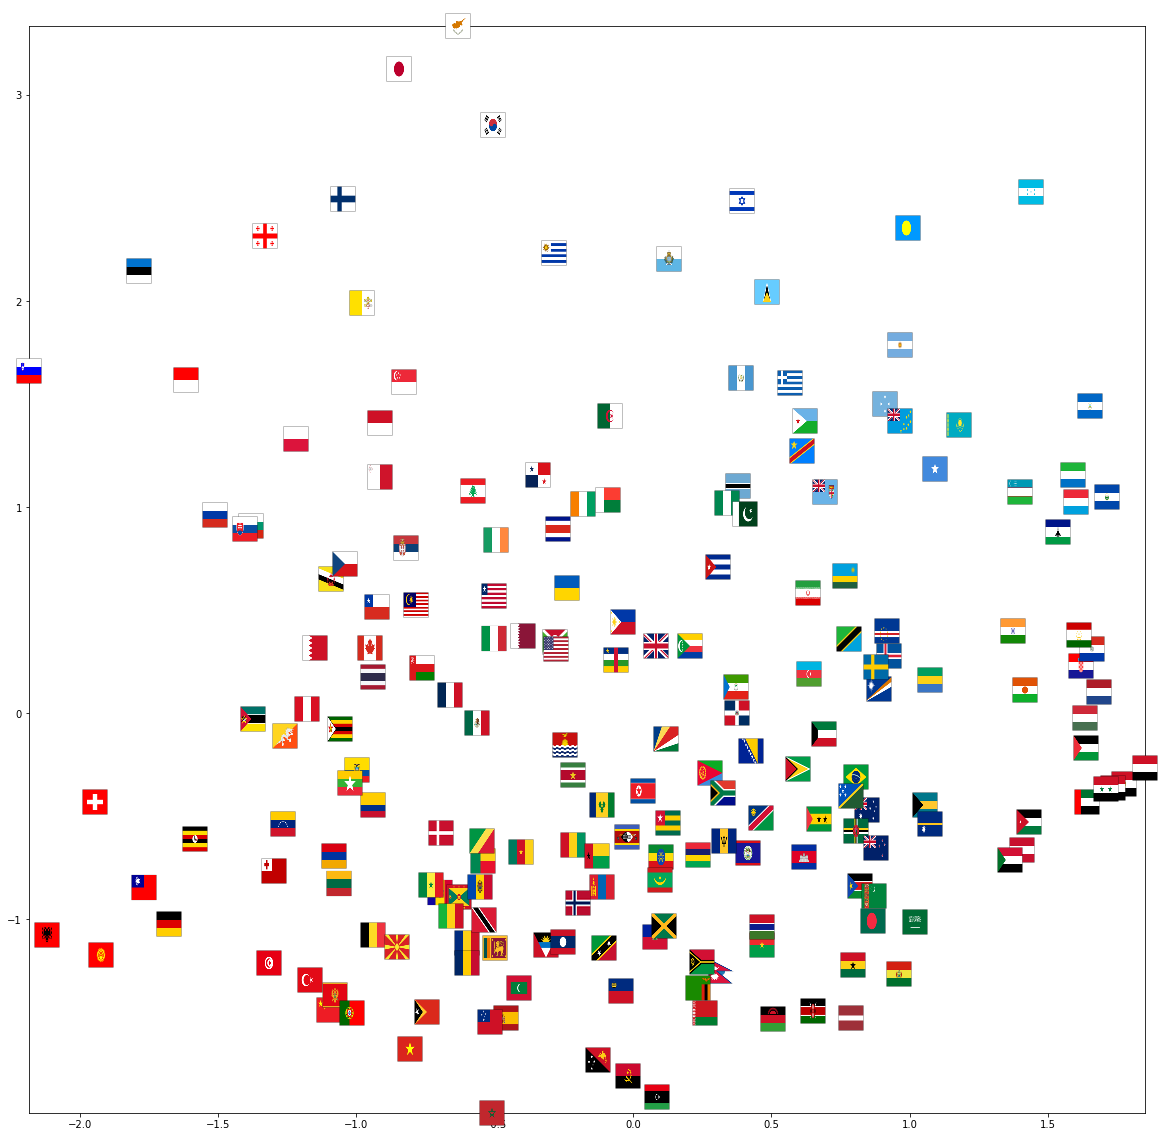

In [265]:
x, y = get_2d_coordinates(mse_matrix_transforms)
plot_flags_2d(x, y)

In [ ]:
x, y = get_2d_coordinates(mse_matrix_edges)
plot_flags_2d(x, y)

c:\Users\321lu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


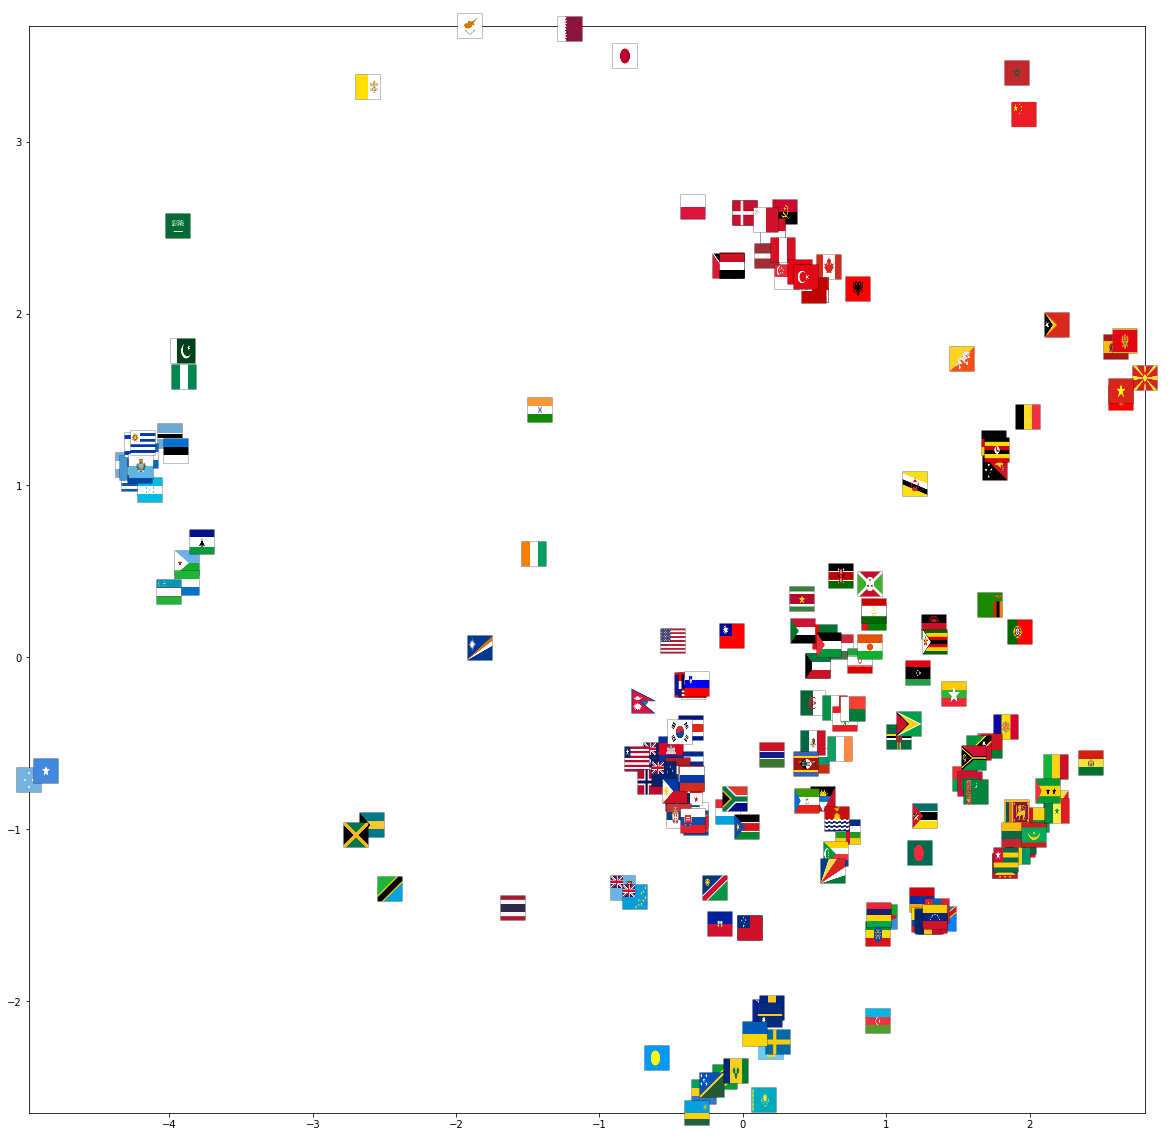

In [264]:
# inv_color_matrix = color_matrix.max() - color_matrix
x, y = get_2d_coordinates(color_dist_matrix)
plot_flags_2d(x, y)

In [ ]:
display_top_pairs(mse_matrix_edges + mse_matrix + color_dist_matrix, amount=100)

In [ ]:
x, y = get_2d_coordinates(mse_matrix_edges + mse_matrix/2 + color_dist_matrix)
plot_flags_2d(x, y)

Test if there's correlation between flag distance and distance between countries

Make slider for importance of each distance type and whilst adjusting it have the flags change position in real time (probably have to use a perceptron of some kind so be able to get those position (parameter) updates)